In [1]:
import sys
import os

In [2]:
sys.path.insert(0, "..")

In [3]:
#imports
import torch
import torch.nn as nn
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
local = True

In [4]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
from config.utils import *
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling1D
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import XRootD

In [5]:
import yaml

with open('../config/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

## Graph Neural Network (with GENConv)

In [6]:
#adding config path for importing GraphDataset class
sys.path.insert(0, "../config")

In [7]:
# Load Dataset
from GraphDataset import GraphDataset
if local:
    file_names = ['~/teams/DSC180A_FA21_A00/a11/train/ntuple_merged_10.root']
    file_names_test = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']
else:
    file_names = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
    file_names_test = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']

graph_dataset = GraphDataset('gdata_train', features, labels, spectators, n_events=1000, n_events_merge=1, 
                             file_names=file_names)

test_dataset = GraphDataset('gdata_test', features, labels, spectators, n_events=2000, n_events_merge=1, 
                             file_names=file_names_test)

## Generators for Training, Testing and Validation

In [8]:
(0.8 * len(graph_dataset)) / 32

23.0

In [9]:
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataListLoader
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate
test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)
print(full_length)
print(train_samples)
print(valid_samples)
print(test_samples)

920
736
184
1889


In [10]:
inputs = 48
hidden = 128
outputs = 1

In [11]:
from torch_geometric.nn import GENConv

In [12]:
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
class GENConv_Classifier(nn.Module):

    def __init__(self, width = hidden, n_inputs = inputs):
        super(GENConv_Classifier, self).__init__()
        self.width = width
        self.act = nn.ReLU

        # Initial linear layers
        self.nn1 = nn.Sequential(
            self.act(),
            nn.Linear(n_inputs, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width)                   
        )
        # Generalized Convolutional layer
        self.conv = GENConv(width, width, num_layers=2, t=1, learn_t=True)

        # Pre-final linear layers
        self.nn2 = nn.Sequential(
            nn.Linear(n_inputs, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
        )
        self.bn = BatchNorm1d(n_inputs)
        # output layer
        self.output = nn.Linear(width, outputs)

    def forward(self, X, edge_index, batch):
        #Normalization → ReLU → GraphConv → Addition
        x = self.bn(X)
        # input layer
        x1 = self.nn1(x)
        #GENConv
        x2 = self.conv(x1, edge_index)
        x3 = scatter_mean(x, batch, dim=0)
        # hidden layers
        x4 = self.nn2(x3)

        # output layer
        x = self.output(x4)
        return x

In [13]:
model = GENConv_Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

## Training/Test Loop as Functions

In [14]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()
    
    #xentropy = nn.CrossEntropyLoss(reduction='mean')
    xentropy = nn.BCEWithLogitsLoss()

    sum_loss = 0.
    #tqdm creates progress bar based on the batch
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_output = torch.flatten(batch_output).float()
        batch_loss_item = xentropy(batch_output, y.float()).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()
    
    #xentropy = nn.CrossEntropyLoss(reduction='mean')
    xentropy = nn.BCEWithLogitsLoss()
    
    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_output = torch.flatten(batch_output).float()
        batch_loss = xentropy(batch_output, y.float())
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [15]:
import os.path as osp

n_epochs = 10
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size, leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size, leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('GENConv_model_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.3866
           Validation Loss: 0.2961
New best model saved to: GENConv_model_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.2494
           Validation Loss: 0.3116
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.1762
           Validation Loss: 0.2548
New best model saved to: GENConv_model_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.1413
           Validation Loss: 0.2405
New best model saved to: GENConv_model_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.1244
           Validation Loss: 0.3152
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.1222
           Validation Loss: 0.2937
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.1093
           Validation Loss: 0.3503
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.1437
           Validation Loss: 0.2547
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.1421
           Validation Loss: 0.2566
Stale epoch
Early stopping after 5 stale epochs


## Testing Evaluation

In [16]:
model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/59.03125 [00:00<?, ?it/s]

In [17]:
y_predict

array([[ -0.9197011],
       [ -7.3749743],
       [ -1.1250291],
       ...,
       [ -0.5045654],
       [-18.691963 ],
       [-10.774979 ]], dtype=float32)

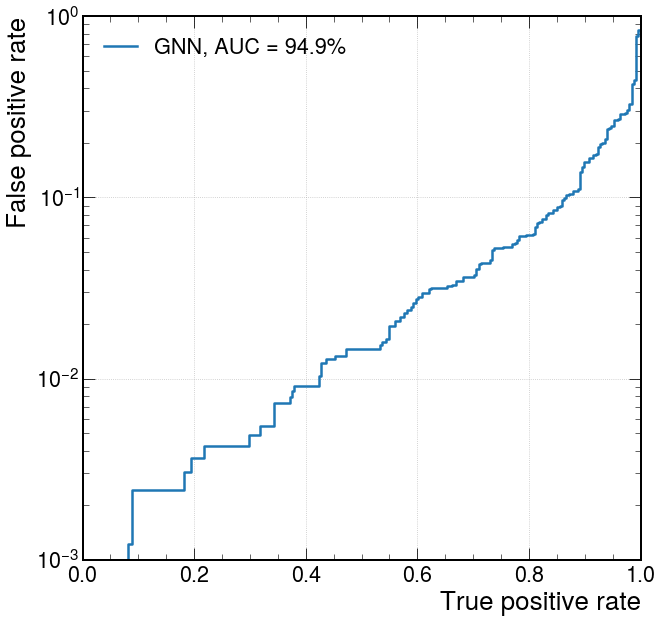

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()